In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install geopandas
!pip install geopy
!pip install lxml
! pip install bs4
! pip install folium
#importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

#libraries for modelling

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


import folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 994 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.4 MB 24.9 MB/s eta 0:00:01
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/py

In [2]:
url_1 = 'https://www.makaan.com/price-trends/property-rates-for-rent-in-goa'
url_2 = 'https://www.makaan.com/price-trends/property-rates-for-rent-in-goa?page=2'
url_3 = 'https://www.makaan.com/price-trends/property-rates-for-rent-in-goa?page=3'



In [3]:
def web_scraper(url,table_no):
    #function to scrap tables from web
    html = requests.get(url).text
    soup = BeautifulSoup(html,'html5lib')
    tables = soup.find_all('table')
    df = pd.read_html(str(tables[table_no]),flavor = 'bs4')[0]
    return df

rent_df = web_scraper(url_1,0)
df2 = web_scraper(url_2,0)
df3 = web_scraper(url_3,0)
rent_df = rent_df.append(df2)
rent_df = rent_df.append(df3)
rent_df.columns = ['Locality','1BHK_rent_range','1BHK_avg_rent','2BHK_rent_range','2BHK_avg_rent','3BHK_rent_range','3BHK_avg_rent']
rent_df.head()
rent_df.shape

,Locality,1BHK_rent_range,1BHK_avg_rent,2BHK_rent_range,2BHK_avg_rent,3BHK_rent_range,3BHK_avg_rent
0,Porvorim,"11,000 - 16,500",14100,28000,28000,"22,000 - 55,000",40250
1,Dabolim,11000,11000,"13,000 - 25,000",19000,-,-
2,Siolim,"14,000 - 28,000",21142.86,30000,30000,-,-
3,Caranzalem,18000,18000,"20,000 - 45,000",28870.97,"23,000 - 1.4 L",43548.39
4,Dona Paula,16000,16000,"20,000 - 55,000",33500,"45,000 - 60,000",50000


(180, 7)

In [4]:
rent_df.Locality.nunique()
rent_df.drop(['1BHK_rent_range','2BHK_rent_range','3BHK_rent_range'],axis =1, inplace = True)
rent_df.shape

#reset index because some of them were messed up
rent_df = rent_df.reset_index()
rent_df.drop(['index'],axis =1 , inplace = True)
rent_df.head()

180

(180, 4)

,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
0,Porvorim,14100,28000,40250
1,Dabolim,11000,19000,-
2,Siolim,21142.86,30000,-
3,Caranzalem,18000,28870.97,43548.39
4,Dona Paula,16000,33500,50000


In [5]:
#dropping all the areas with no data
rent_df.drop(list(rent_df[(rent_df['1BHK_avg_rent'] == '-') & (rent_df['2BHK_avg_rent'] == '-') &( rent_df['3BHK_avg_rent']== '-')].index),axis = 0,inplace= True)
rent_df.shape
rent_df.head()

(61, 4)

,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
0,Porvorim,14100,28000,40250
1,Dabolim,11000,19000,-
2,Siolim,21142.86,30000,-
3,Caranzalem,18000,28870.97,43548.39
4,Dona Paula,16000,33500,50000


In [6]:
#filling NA values with avg change in rent across various
rent_df.replace('-',np.nan,inplace = True)
rent_df.dtypes
rent_df.isna().sum()
rent_df[['1BHK_avg_rent','2BHK_avg_rent','3BHK_avg_rent']] = rent_df[['1BHK_avg_rent','2BHK_avg_rent','3BHK_avg_rent']].astype(float)
rent_df.dtypes

Locality         object
1BHK_avg_rent    object
2BHK_avg_rent    object
3BHK_avg_rent    object
dtype: object

Locality          0
1BHK_avg_rent    33
2BHK_avg_rent    14
3BHK_avg_rent    33
dtype: int64

Locality          object
1BHK_avg_rent    float64
2BHK_avg_rent    float64
3BHK_avg_rent    float64
dtype: object

In [7]:
#rent factor calculation between bhks
two_to_one  = np.nanmean(rent_df['1BHK_avg_rent'].astype(float))/np.nanmean(rent_df['2BHK_avg_rent'].astype(float))
two_to_three = np.nanmean(rent_df['3BHK_avg_rent'].astype(float))/np.nanmean(rent_df['2BHK_avg_rent'].astype(float))
one_to_three = np.nanmean(rent_df['3BHK_avg_rent'].astype(float))/np.nanmean(rent_df['1BHK_avg_rent'].astype(float))
one_to_two = np.nanmean(rent_df['2BHK_avg_rent'].astype(float))/np.nanmean(rent_df['1BHK_avg_rent'].astype(float))
three_to_two = np.nanmean(rent_df['2BHK_avg_rent'].astype(float))/np.nanmean(rent_df['3BHK_avg_rent'].astype(float))
three_to_one = np.nanmean(rent_df['1BHK_avg_rent'].astype(float))/np.nanmean(rent_df['3BHK_avg_rent'].astype(float))


In [8]:
#1BHK & 3BHK none
lst = list(rent_df[(rent_df['1BHK_avg_rent'].isna() == True)&(rent_df['3BHK_avg_rent'].isna()== True)].index)
lst
rent_df.loc[lst,:]
rent_df.loc[lst,'1BHK_avg_rent'] = list(rent_df.loc[lst,'2BHK_avg_rent'] * two_to_one)
rent_df.loc[lst,'3BHK_avg_rent'] = list(rent_df.loc[lst,'2BHK_avg_rent'] * two_to_three)
rent_df.loc[lst,:]

[11, 23, 25, 37, 38, 42, 44, 46, 50, 51, 55, 57, 97, 105, 108, 109, 123, 124]

,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
11,Aldona,NaN,30000.00,NaN
23,Vasco Da Gama,NaN,10750.00,NaN
25,Bambolim,NaN,45100.00,NaN
37,Santa Cruz,NaN,16000.00,NaN
38,Corlim,NaN,15000.00,NaN
42,Zuarinagar,NaN,15000.00,NaN
44,Ponda,NaN,16000.00,NaN
46,Nagoa,NaN,17000.00,NaN
50,Saligao,NaN,19666.67,NaN
51,Pernem,NaN,20000.00,NaN


,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
11,Aldona,19353.917256,30000.00,60472.632583
23,Vasco Da Gama,6935.153683,10750.00,21669.360009
25,Bambolim,29095.388942,45100.00,90910.524316
37,Santa Cruz,10322.089203,16000.00,32252.070711
38,Corlim,9676.958628,15000.00,30236.316291
42,Zuarinagar,9676.958628,15000.00,30236.316291
44,Ponda,10322.089203,16000.00,32252.070711
46,Nagoa,10967.219778,17000.00,34267.825130
50,Saligao,12687.570129,19666.67,39643.176968
51,Pernem,12902.611504,20000.00,40315.088388


In [9]:
#2BHK & 3BHk none
lst = list(rent_df[(rent_df['2BHK_avg_rent'].isna() == True)&(rent_df['3BHK_avg_rent'].isna()== True)].index)
lst
rent_df.loc[lst,:]
rent_df.loc[lst,'2BHK_avg_rent'] = list(rent_df.loc[lst,'1BHK_avg_rent'] * one_to_two)
rent_df.loc[lst,'3BHK_avg_rent'] = list(rent_df.loc[lst,'1BHK_avg_rent'] * one_to_three)
rent_df.loc[lst,:]

[6, 17, 24, 59, 63, 73, 110]

,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
6,Nerul,21500.0,NaN,NaN
17,Vagator,22000.0,NaN,NaN
24,Velha,6000.0,NaN,NaN
59,Sateri Nagar Colony,13000.0,NaN,NaN
63,Baga,15000.0,NaN,NaN
73,Betim,20000.0,NaN,NaN
110,Mangaddo,8000.0,NaN,NaN


,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
6,Nerul,21500.0,33326.586627,67178.214277
17,Vagator,22000.0,34101.623525,68740.498330
24,Velha,6000.0,9300.442780,18747.408635
59,Sateri Nagar Colony,13000.0,20150.959356,40619.385377
63,Baga,15000.0,23251.106949,46868.521588
73,Betim,20000.0,31001.475932,62491.362118
110,Mangaddo,8000.0,12400.590373,24996.544847


In [10]:
#1BHK and 2 BHK none
lst = list(rent_df[(rent_df['1BHK_avg_rent'].isna() == True)&(rent_df['2BHK_avg_rent'].isna()== True)].index)
lst
rent_df.loc[lst,:]
rent_df.loc[lst,'1BHK_avg_rent'] = list(rent_df.loc[lst,'3BHK_avg_rent'] * three_to_one)
rent_df.loc[lst,'2BHK_avg_rent'] = list(rent_df.loc[lst,'3BHK_avg_rent'] * three_to_two)
rent_df.loc[lst,:]

[36, 49, 53, 68]

,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
36,Marcel,NaN,NaN,60000.0
49,Guirim,NaN,NaN,25000.0
53,Aldeia de Goa,NaN,NaN,125000.0
68,Santa Inez,NaN,NaN,30000.0


,Locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
36,Marcel,19202.653924,29765.530673,60000.0
49,Guirim,8001.105802,12402.304447,25000.0
53,Aldeia de Goa,40005.529009,62011.522235,125000.0
68,Santa Inez,9601.326962,14882.765336,30000.0


In [11]:
#1BHK none 
lst = rent_df[rent_df['1BHK_avg_rent'].isna() == True].index
rent_df.loc[lst,'1BHK_avg_rent'] = list(rent_df.loc[lst,'2BHK_avg_rent'] * two_to_one)

#2bhk none
lst = rent_df[rent_df['2BHK_avg_rent'].isna() == True].index
rent_df.loc[lst,'2BHK_avg_rent'] = list(rent_df.loc[lst,'1BHK_avg_rent'] * one_to_two)

#3bhk none
lst = rent_df[rent_df['3BHK_avg_rent'].isna() == True].index
rent_df.loc[lst,'3BHK_avg_rent'] = list(rent_df.loc[lst,'2BHK_avg_rent'] * two_to_three)

rent_df.isna().sum()

Locality         0
1BHK_avg_rent    0
2BHK_avg_rent    0
3BHK_avg_rent    0
dtype: int64

In [12]:
rent_df['State'] = ',Goa,India'
rent_df["locality"]= rent_df['Locality']+rent_df['State']
rent_df.drop(['Locality','State'],axis = 1 ,inplace = True)
rent_df = rent_df[['locality','1BHK_avg_rent','2BHK_avg_rent','3BHK_avg_rent']]

locator = Nominatim(user_agent='myGeocoder')

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
rent_df['location'] = rent_df['locality'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
rent_df['point'] = rent_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
rent_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(rent_df['point'].tolist(), index=rent_df.index)
rent_df.drop(['location','altitude'],axis = 1, inplace = True)
rent_df.shape
rent_df.head(3)

(61, 7)

,locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent,point,latitude,longitude
0,"Porvorim,Goa,India",14100.00,28000.0,40250.000000,"(15.5474192, 73.8187636, 0.0)",15.547419,73.818764
1,"Dabolim,Goa,India",11000.00,19000.0,38299.333969,"(15.3865713, 73.8514049, 0.0)",15.386571,73.851405
2,"Siolim,Goa,India",21142.86,30000.0,60472.632583,"(15.6243358, 73.7660284, 0.0)",15.624336,73.766028


In [13]:
# # #imputing manually 
# # rent_df[rent_df['point'].isna() == True].index
# # rent_df[rent_df['point'].isna() == True]

# # rent_df.iloc[13,4] = (15.58924322543365,73.8437812784861,0)
# # # rent_df.loc[19,'latitude','longitude'] = (15.546068001053197, 73.84769006656738,0)
# # # rent_df.loc[36,'latitude','longitude'] = (15.518128711003422, 73.96243784566643,0)
# # # rent_df.loc[39,'latitude','longitude'] =  (15.525505751573125, 73.83973019626907,0)
# # # rent_df.loc[42,'latitude','longitude'] =  (15.378868449212765, 73.88010942209577,0)
# # # rent_df.loc[55,'latitude','longitude'] = (15.600983840780728, 73.82703788766187,0)
# # # rent_df.loc[57,'latitude','longitude'] = (15.542326136765237, 73.81494320024629,0)
# # # rent_df.loc[59,'latitude','longitude'] = (15.58113686146022, 73.79504341328625,0)
# # # rent_df.loc[108,'latitude','longitude'] = (15.390802463635652, 74.01416529455267,0)
# # # rent_df.loc[110,'latitude','longitude'] = (15.499269185823449, 73.94521292639455,0)
# # # rent_df.loc[123,'latitude','longitude'] = (15.398268343775856, 74.0098226139682,0)
# rent_df[rent_df['point'].isna() == True]

In [14]:
missing_loc = rent_df[rent_df['point'].isna() == True]
missing_loc = missing_loc.reset_index()
missing_loc.drop(['index'],axis =1, inplace = True)
missing_loc.drop(7,axis =0, inplace = True)
missing_loc['latitude'] = [15.58924322543365,15.546068001053197,15.518128711003422,15.525505751573125,15.378868449212765,15.600983840780728,15.542326136765237,15.58113686146022,15.390802463635652,15.499269185823449,15.398268343775856]
missing_loc['longitude'] = [73.8437812784861,73.84769006656738,73.96243784566643,73.83973019626907,73.88010942209577,73.82703788766187,73.81494320024629,73.79504341328625,74.01416529455267,73.94521292639455,74.0098226139682]
rent_df.drop(rent_df[rent_df['point'].isna() == True].index,axis = 0, inplace = True)
rent_df.shape

(49, 7)

In [15]:
#appending the dataframe to original df
rent_df  = rent_df.append(missing_loc,ignore_index = True)
rent_df.shape
rent_df.drop(['point'],axis =1,inplace = True)

(60, 7)

In [16]:
#plotting our locations

latitude = np.mean(rent_df.latitude)
longitude = np.mean(rent_df.longitude)

goa_map= folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around center



# add coordinates to the map as blue circle markers
for lat, lng, label in zip(rent_df.latitude, rent_df.longitude, rent_df['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.5
        ).add_to(goa_map)

goa_map



Text(0.5, 0.98, 'Rent distribution across different neighborhoods of Goa')

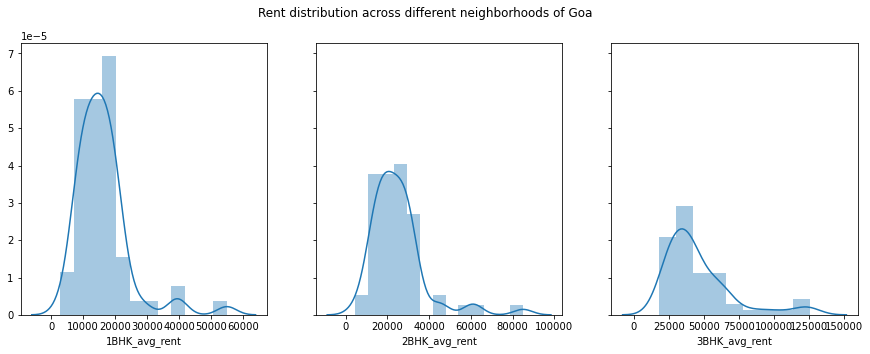

In [17]:
#plotting rent distribution across goa
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

fig.suptitle('Rent distribution across different neighborhoods of Goa')

sns.distplot(rent_df['1BHK_avg_rent'],ax = axes[0])

sns.distplot(rent_df['2BHK_avg_rent'],ax=axes[1])

sns.distplot(rent_df['3BHK_avg_rent'],ax=axes[2])


# Getting venues from foursquare api

In [18]:
CLIENT_ID = 'PEUDGWED3WQGNY5EVU2XS00V3X4Q5FOUMTO5ACCIVCWALP1T' # your Foursquare ID
CLIENT_SECRET = 'M4WVVVHFZBTYTAGHB3IK54QPR05ZUT2RJMZTUZP5DXMQUS5R' # your Foursquare Secret
VERSION = '20210710'
LIMIT = 100

In [19]:
# # Select first building (which in our case is BedokVille):
# locality= rent_df.loc[0, 'locality']
# neighborhood_latitude =rent_df.loc[0, 'latitude'] 
# neighborhood_longitude = rent_df.loc[0, 'longitude'] 

# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 2000


In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if results!=[]:
        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_latitude', 
                  'Neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

In [22]:
venue_names = getNearbyVenues(names=rent_df['locality'],
                                   latitudes=rent_df['latitude'],
                                   longitudes=rent_df['longitude']
                                  )
venue_names.head()

Porvorim,Goa,India
Dabolim,Goa,India
Siolim,Goa,India
Caranzalem,Goa,India
Dona Paula,Goa,India
Mapusa,Goa,India
Nerul,Goa,India
Dona Paula Road,Goa,India
Candolim,Goa,India
Calangute,Goa,India
Miramar Circle,Goa,India
Aldona,Goa,India
Salcete,Goa,India
Taleigao,Goa,India
Arpora,Goa,India
Assagao,Goa,India
Vagator,Goa,India
Anjuna,Goa,India
Old Goa Road,Goa,India
Sancoale,Goa,India
Vasco Da Gama,Goa,India
Velha,Goa,India
Bambolim,Goa,India
Mormugao,Goa,India
Sangolda,Goa,India
Margao,Goa,India
Socorro,Goa,India
Moira,Goa,India
Panjim,Goa,India
Parra,Goa,India
Santa Cruz,Goa,India
Corlim,Goa,India
Ribandar,Goa,India
St Inez,Goa,India
Ponda,Goa,India
Nagoa,Goa,India
Guirim,Goa,India
Saligao,Goa,India
Pernem,Goa,India
Aldeia de Goa,Goa,India
Taleigao Road,Goa,India
Tiswadi,Goa,India
Baga,Goa,India
Santa Inez,Goa,India
Betim,Goa,India
Campal Beach Resort,Goa,India
Duler Ground Road,Goa,India
Mala,Goa,India
Vaddem New Vaddem,Goa,India
kadamba plateau,Goa,India
Donwaddo Salvador Do Mundo Bar

,Neighborhood,Neighborhood_latitude,Neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,"Porvorim,Goa,India",15.547419,73.818764,Copperleaf,15.549013,73.815212,Goan Restaurant
1,"Porvorim,Goa,India",15.547419,73.818764,The Backyard,15.543808,73.812395,BBQ Joint
2,"Porvorim,Goa,India",15.547419,73.818764,Bakers Street,15.538428,73.818051,Bakery
3,"Porvorim,Goa,India",15.547419,73.818764,Kudo's sizzlers & Pizzeria,15.536935,73.819548,Taco Place
4,"Porvorim,Goa,India",15.547419,73.818764,Angels Resort,15.536030,73.820715,Resort


## One hot encoding the venue_category

In [23]:
sorted(dict(venue_names.groupby('Neighborhood')['venue_category'].count()).items(),key=lambda x: x[1], reverse=True)[0:15]
       

[('Anjuna,Goa,India', 100),
 ('Baga,Goa,India', 100),
 ('Candolim,Goa,India', 100),
 ('Vagator,Goa,India', 87),
 ('Aldeia de Goa,Goa,India', 82),
 ('Calangute,Goa,India', 80),
 ('Betim,Goa,India', 77),
 ('Arpora,Goa,India', 71),
 ('Santa Inez,Goa,India', 67),
 ('St Inez,Goa,India', 67),
 ('Mala,Goa,India', 66),
 ('Campal Beach Resort,Goa,India', 65),
 ('Panjim,Goa,India', 64),
 ('Nerul,Goa,India', 56),
 ('Miramar Circle,Goa,India', 35)]

In [24]:
rent_df.sort_values(by = ['1BHK_avg_rent', '2BHK_avg_rent','3BHK_avg_rent'], ascending = [False, False,False], na_position = 'first')[0:15]

,locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent,latitude,longitude
17,"Anjuna,Goa,India",54836.098892,85000.000000,25000.000000,15.584865,73.743944
39,"Aldeia de Goa,Goa,India",40005.529009,62011.522235,125000.000000,15.599179,73.742281
27,"Moira,Goa,India",38707.834512,60000.000000,35000.000000,15.600523,73.844108
22,"Bambolim,Goa,India",29095.388942,45100.000000,90910.524316,15.458954,73.858979
50,"Donwaddo Salvador Do Mundo Bardez,Goa,India",25000.000000,17000.000000,34267.825130,15.546068,73.847690
8,"Candolim,Goa,India",22250.000000,45000.000000,102500.000000,15.520153,73.765942
16,"Vagator,Goa,India",22000.000000,34101.623525,68740.498330,15.597520,73.738871
6,"Nerul,Goa,India",21500.000000,33326.586627,67178.214277,15.497595,73.782538
2,"Siolim,Goa,India",21142.860000,30000.000000,60472.632583,15.624336,73.766028
7,"Dona Paula Road,Goa,India",20000.000000,33700.000000,40000.000000,15.452657,73.802558


In [25]:
venue_names['dummy'] = 1
table = pd.pivot_table(venue_names, values ='dummy' , index=['Neighborhood'],
                    columns=['venue_category'], aggfunc=np.sum)
table = table.reset_index()
table.fillna(0,inplace = True)
table.rename(columns = {'Neighborhood':'locality'}, inplace = True)
table.head()
#table.drop(['venue_category'],axis =1, inplace = True)

venue_category,locality,ATM,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Aldeia de Goa,Goa,India",0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Aldona,Goa,India",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Alto Porvorim,Goa,India",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Anjuna,Goa,India",0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Arpora,Goa,India",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Mergeing both rent dataset and venue dataset

In [26]:
merged_ads = rent_df.merge(table, left_on='locality', right_on='locality')
merged_ads.head()

,locality,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent,latitude,longitude,ATM,Airport,Airport Lounge,Airport Service,...,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Porvorim,Goa,India",14100.00,28000.00,40250.000000,15.547419,73.818764,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,"Dabolim,Goa,India",11000.00,19000.00,38299.333969,15.386571,73.851405,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Siolim,Goa,India",21142.86,30000.00,60472.632583,15.624336,73.766028,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Caranzalem,Goa,India",18000.00,28870.97,43548.390000,15.465057,73.803626,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Dona Paula,Goa,India",16000.00,33500.00,50000.000000,15.452657,73.802558,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#clustering
features = merged_ads.drop(['locality','latitude','longitude'],axis = 1)
features.head()

,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent,ATM,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,...,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Yoga Studio
0,14100.00,28000.00,40250.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,11000.00,19000.00,38299.333969,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21142.86,30000.00,60472.632583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18000.00,28870.97,43548.390000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16000.00,33500.00,50000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

Text(0.5, 0, 'Values of K')

Text(0, 0.5, 'Distortion')

Text(0.5, 1.0, 'The Elbow Method using Distortion')

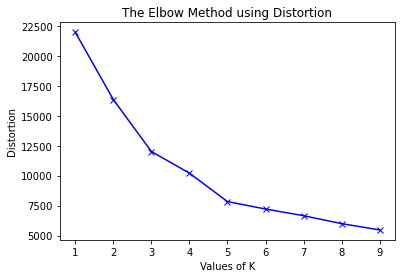

In [28]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(features)
    kmeanModel.fit(features)
 
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / features.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(features, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / features.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [29]:
n = 5
kmeans = KMeans(n_clusters = 5,random_state = 0 ).fit(features)
merged_ads['final_cluster'] = kmeans.labels_

In [30]:
merged_ads.groupby('final_cluster')['1BHK_avg_rent','2BHK_avg_rent','3BHK_avg_rent'].mean()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


,1BHK_avg_rent,2BHK_avg_rent,3BHK_avg_rent
final_cluster,,,
0,15514.945804,23460.134239,40337.042564
1,25170.183590,41788.970447,112323.038863
2,18360.561949,29524.798187,62101.819413
3,46771.966702,72500.000000,30000.000000
4,9449.477289,14266.812260,26577.951634


In [31]:
#plotting all the places based on map
#plotting our locations

latitude = np.mean(rent_df.latitude)
longitude = np.mean(rent_df.longitude)

goa_map= folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around center



# add coordinates to the map as blue circle markers
for lat, lng, label in zip(merged_ads[merged_ads['final_cluster'] == 0].latitude, merged_ads[merged_ads['final_cluster'] == 0].longitude,merged_ads[merged_ads['final_cluster'] == 0]['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.5
        ).add_to(goa_map)
    
for lat, lng, label in zip(merged_ads[merged_ads['final_cluster'] == 1].latitude, merged_ads[merged_ads['final_cluster'] == 1].longitude,merged_ads[merged_ads['final_cluster'] == 1]['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.5
        ).add_to(goa_map)
    
for lat, lng, label in zip(merged_ads[merged_ads['final_cluster'] == 2].latitude, merged_ads[merged_ads['final_cluster'] == 2].longitude,merged_ads[merged_ads['final_cluster'] == 2]['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.5
        ).add_to(goa_map)

for lat, lng, label in zip(merged_ads[merged_ads['final_cluster'] == 3].latitude, merged_ads[merged_ads['final_cluster'] == 3].longitude,merged_ads[merged_ads['final_cluster'] == 3]['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.5
        ).add_to(goa_map)

for lat, lng, label in zip(merged_ads[merged_ads['final_cluster'] == 4].latitude, merged_ads[merged_ads['final_cluster'] == 4].longitude,merged_ads[merged_ads['final_cluster'] == 4]['locality']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='indigo',
        fill_color='indigo',
        fill_opacity=0.5
        ).add_to(goa_map)

goa_map


In [32]:
#seeing what venues dominate in each cluster
venues = dict(merged_ads[merged_ads['final_cluster'] == 0].loc[:,'ATM':'Yoga Studio'].sum())
top_venues = sorted(venues.items(), key=lambda x: x[1], reverse=True)
top_venues[0:15]

[('Indian Restaurant', 74.0),
 ('Hotel', 37.0),
 ('Café', 34.0),
 ('Restaurant', 34.0),
 ('Seafood Restaurant', 31.0),
 ('Resort', 27.0),
 ('Ice Cream Shop', 18.0),
 ('Beach', 17.0),
 ('Bakery', 15.0),
 ('Casino', 13.0),
 ('Coffee Shop', 13.0),
 ('Asian Restaurant', 12.0),
 ('Shopping Mall', 11.0),
 ('Breakfast Spot', 10.0),
 ('Clothing Store', 10.0)]

In [33]:
#seeing what venues dominate in each cluster
venues = dict(merged_ads[merged_ads['final_cluster'] == 1].loc[:,'ATM':'Yoga Studio'].sum())
top_venues = sorted(venues.items(), key=lambda x: x[1], reverse=True)
top_venues[0:15]

[('Indian Restaurant', 34.0),
 ('Hotel', 28.0),
 ('Resort', 21.0),
 ('Restaurant', 19.0),
 ('Seafood Restaurant', 18.0),
 ('Beach', 13.0),
 ('Café', 13.0),
 ('Bar', 10.0),
 ('Asian Restaurant', 9.0),
 ('Nightclub', 6.0),
 ('Coffee Shop', 5.0),
 ('Juice Bar', 5.0),
 ('BBQ Joint', 4.0),
 ('Goan Restaurant', 4.0),
 ('Italian Restaurant', 4.0)]

In [34]:
#seeing what venues dominate in each cluster
venues = dict(merged_ads[merged_ads['final_cluster'] == 2].loc[:,'ATM':'Yoga Studio'].sum())
top_venues = sorted(venues.items(), key=lambda x: x[1], reverse=True)
top_venues[0:15]

[('Hotel', 38.0),
 ('Indian Restaurant', 33.0),
 ('Restaurant', 30.0),
 ('Café', 23.0),
 ('Seafood Restaurant', 14.0),
 ('Bar', 11.0),
 ('Beach', 11.0),
 ('Ice Cream Shop', 11.0),
 ('Resort', 11.0),
 ('Asian Restaurant', 10.0),
 ('Bakery', 10.0),
 ('Pizza Place', 10.0),
 ('Vegetarian / Vegan Restaurant', 10.0),
 ('Italian Restaurant', 9.0),
 ('Breakfast Spot', 8.0)]

In [35]:
#seeing what venues dominate in each cluster
venues = dict(merged_ads[merged_ads['final_cluster'] == 3].loc[:,'ATM':'Yoga Studio'].sum())
top_venues = sorted(venues.items(), key=lambda x: x[1], reverse=True)
top_venues[0:15]

[('Restaurant', 9.0),
 ('Café', 8.0),
 ('Indian Restaurant', 7.0),
 ('Bar', 6.0),
 ('Beach', 6.0),
 ('Nightclub', 6.0),
 ('Hotel', 5.0),
 ('Pizza Place', 4.0),
 ('Breakfast Spot', 3.0),
 ('Lounge', 3.0),
 ('Asian Restaurant', 2.0),
 ('Bed & Breakfast', 2.0),
 ('Burger Joint', 2.0),
 ('Dive Bar', 2.0),
 ('French Restaurant', 2.0)]

In [36]:
#seeing what venues dominate in each cluster
venues = dict(merged_ads[merged_ads['final_cluster'] == 4].loc[:,'ATM':'Yoga Studio'].sum())
top_venues = sorted(venues.items(), key=lambda x: x[1], reverse=True)
top_venues[0:15]

[('Indian Restaurant', 26.0),
 ('Café', 13.0),
 ('Hotel', 12.0),
 ('Ice Cream Shop', 11.0),
 ('Restaurant', 11.0),
 ('Bakery', 8.0),
 ('Pizza Place', 8.0),
 ('Seafood Restaurant', 8.0),
 ('Coffee Shop', 7.0),
 ('Gym', 7.0),
 ('Vegetarian / Vegan Restaurant', 6.0),
 ('Dessert Shop', 5.0),
 ('Bar', 4.0),
 ('Beach', 4.0),
 ('Fast Food Restaurant', 4.0)]

In [37]:
list(merged_ads[merged_ads['final_cluster'] == 0]['locality'])
list(merged_ads[merged_ads['final_cluster'] == 1]['locality'])
list(merged_ads[merged_ads['final_cluster'] == 2]['locality'])
list(merged_ads[merged_ads['final_cluster'] == 3]['locality'])
list(merged_ads[merged_ads['final_cluster'] == 4]['locality'])

['Porvorim,Goa,India',
 'Dabolim,Goa,India',
 'Caranzalem,Goa,India',
 'Mapusa,Goa,India',
 'Dona Paula Road,Goa,India',
 'Calangute,Goa,India',
 'Miramar Circle,Goa,India',
 'Taleigao,Goa,India',
 'Old Goa Road,Goa,India',
 'Panjim,Goa,India',
 'Ribandar,Goa,India',
 'Saligao,Goa,India',
 'Pernem,Goa,India',
 'Taleigao Road,Goa,India',
 'Baga,Goa,India',
 'Mala,Goa,India',
 'Donwaddo Salvador Do Mundo Bardez,Goa,India',
 'Alto Porvorim,Goa,India',
 'Peddem,Goa,India',
 'Porvorim Alto Porvorim,Goa,India',
 'Sateri Nagar Colony,Goa,India',
 'Shantinagar,Goa,India']

['Candolim,Goa,India',
 'Arpora,Goa,India',
 'Bambolim,Goa,India',
 'Sangolda,Goa,India',
 'Aldeia de Goa,Goa,India']

['Siolim,Goa,India',
 'Dona Paula,Goa,India',
 'Nerul,Goa,India',
 'Aldona,Goa,India',
 'Assagao,Goa,India',
 'Vagator,Goa,India',
 'Socorro,Goa,India',
 'Parra,Goa,India',
 'St Inez,Goa,India',
 'Betim,Goa,India',
 'Campal Beach Resort,Goa,India',
 'Marcel,Goa,India']

['Anjuna,Goa,India', 'Moira,Goa,India']

['Salcete,Goa,India',
 'Sancoale,Goa,India',
 'Vasco Da Gama,Goa,India',
 'Velha,Goa,India',
 'Mormugao,Goa,India',
 'Margao,Goa,India',
 'Santa Cruz,Goa,India',
 'Corlim,Goa,India',
 'Ponda,Goa,India',
 'Nagoa,Goa,India',
 'Guirim,Goa,India',
 'Tiswadi,Goa,India',
 'Santa Inez,Goa,India',
 'Duler Ground Road,Goa,India',
 'Vaddem New Vaddem,Goa,India',
 'kadamba plateau,Goa,India',
 'Zuarinagar,Goa,India',
 'Kurtarkar Nagari,Goa,India',
 'Mangaddo,Goa,India']